In [1]:
# Install fasttext,torch if not already installed
!pip install fasttext
!pip install torch

In [2]:
import numpy as np
import fasttext
import fasttext.util
import os
from collections import defaultdict
from scipy.linalg import orthogonal_procrustes
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# Data Preparation

In [4]:
# --- English Model ---
en_model_path = 'cc.en.300.bin'
if not os.path.exists(en_model_path):
    print("Downloading English fastText model...")
    fasttext.util.download_model('en', if_exists='ignore')
    os.rename('cc.en.300.bin', en_model_path)
    print("English model downloaded.")
else:
    print("English model already exists.")

print("Loading English model...")
en_model = fasttext.load_model(en_model_path)
print("English model loaded.")

# Deleting the downloaded file to free up disk space
if os.path.exists(en_model_path):
    os.remove(en_model_path)
    print("English model download file deleted.")

# --- Hindi Model ---
hi_model_path = 'cc.hi.300.bin'
if not os.path.exists(hi_model_path):
    print("Downloading Hindi fastText model...")
    fasttext.util.download_model('hi', if_exists='ignore')
    os.rename('cc.hi.300.bin', hi_model_path)
    print("Hindi model downloaded.")
else:
    print("Hindi model already exists.")

print("Loading Hindi model...")
hi_model = fasttext.load_model(hi_model_path)
print("Hindi model loaded.")

English model downloaded.
Loading English model...
English model loaded.
English model download file deleted.
Hindi model already exists.
Loading Hindi model...
Hindi model loaded.


In [5]:
#Checking if we are able to get vectors from models
english_word = "hello"
hindi_word = "राजकुमारी"

try:
  english_vector = en_model.get_word_vector(english_word)
  print(f"Vector for '{english_word}': {english_vector[:5]}...") # Print first 5 elements

  hindi_vector = hi_model.get_word_vector(hindi_word)
  print(f"Vector for '{hindi_word}': {hindi_vector[:5]}...") # Print first 5 elements

except KeyError as e:
    print(f"Error: Word '{e}' not found in the model vocabulary.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Vector for 'hello': [ 0.15757619  0.04378209 -0.00451272  0.06659314  0.07703468]...
Vector for 'राजकुमारी': [0.0275354  0.00600677 0.00590774 0.03287324 0.01008815]...


In [6]:
def extract_translation_pairs(filepath):
    """
    Extracts word translation pairs from a MUSE dictionary file.

    Args:
        filepath (str): Path to the dictionary file.

    Returns:
        List[Tuple[str, str]]: List of (source_word, target_word) tuples.
    """
    pairs = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                source_word, target_word = line.strip().split()
                pairs.append((source_word, target_word))
            except ValueError:
                continue
    return pairs

In [7]:
# Download the bilingual dictionaries (you can comment these if already downloaded)
#!curl -Lo hi-en.txt https://dl.fbaipublicfiles.com/arrival/dictionaries/hi-en.txt
#!curl -Lo en-hi.txt https://dl.fbaipublicfiles.com/arrival/dictionaries/en-hi.txt

# Extract word pairs (here using English to Hindi pairs)
en_hi_pairs = extract_translation_pairs('en-hi.txt')

print(f"Extracted {len(en_hi_pairs)} English-Hindi pairs.")
print("First 5 English-Hindi pairs:", en_hi_pairs[:5])

Extracted 38221 English-Hindi pairs.
First 5 English-Hindi pairs: [('and', 'और'), ('was', 'था'), ('was', 'थी'), ('for', 'लिये'), ('that', 'उस')]


In [8]:
def align_embeddings(src_embeddings, tgt_embeddings):
    """
    Aligns source embeddings to target embeddings using Orthogonal Procrustes.

    Args:
        src_embeddings (np.ndarray): Source word embeddings (n x d).
        tgt_embeddings (np.ndarray): Target word embeddings (n x d).

    Returns:
        Tuple[np.ndarray, np.ndarray]: (Aligned source embeddings, rotation matrix)
    """
    # Find rotation matrix to map source embeddings to target space.
    rotation, _ = orthogonal_procrustes(src_embeddings, tgt_embeddings)
    aligned_src_embeddings = np.dot(src_embeddings, rotation)
    return aligned_src_embeddings, rotation

# Embedding Alignment

In [10]:
# Prepare embeddings for the bilingual lexicon (using English-Hindi pairs)
english_embeddings = np.array([
    en_model.get_word_vector(en_word) for en_word, hi_word in en_hi_pairs
])
hindi_embeddings = np.array([
    hi_model.get_word_vector(hi_word) for en_word, hi_word in en_hi_pairs
])

# Align English embeddings into Hindi space.
aligned_english_embeddings, rotation_matrix = align_embeddings(english_embeddings, hindi_embeddings)
print("Alignment completed.")

Alignment completed.


# Evaluation

In [12]:
def normalize_embeddings(embeddings):
    """
    Normalize word embeddings to unit vectors (for cosine similarity).

    Args:
        embeddings (np.ndarray): Embedding matrix of shape (n, d).

    Returns:
        np.ndarray: Normalized embedding matrix.
    """
    norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
    return embeddings / norms

def get_top_k_neighbors(query_vector, tgt_embeddings, tgt_words, k=5):
    """
    Finds the top-k nearest neighbors using cosine similarity.

    Args:
        query_vector (np.ndarray): Aligned embedding vector for a source word.
        tgt_embeddings (np.ndarray): Normalized target embedding matrix (n x d).
        tgt_words (List[str]): List of target words.
        k (int): Number of neighbors to return.

    Returns:
        List[str]: List of top-k nearest target words.
    """
    query_norm = query_vector / np.linalg.norm(query_vector)
    similarities = np.dot(tgt_embeddings, query_norm)
    top_k_indices = np.argsort(-similarities)[:k]
    return [tgt_words[i] for i in top_k_indices]

def evaluate_translation(
    translation_pairs,
    en_model,
    hi_model,
    rotation_matrix,
    top_k=[1, 5],
    max_vocab_size=50000,
    verbose=True
):
    """
    Evaluates translation accuracy using a test dictionary and aligned embeddings.

    Args:
        translation_pairs (List[Tuple[str, str]]): Test (English, Hindi) word pairs.
        en_model (FastText model): Pre-trained English FastText model.
        hi_model (FastText model): Pre-trained Hindi FastText model.
        rotation_matrix (np.ndarray): Mapping from English to Hindi embedding space.
        top_k (List[int]): Values of 'k' for Precision@k.
        max_vocab_size (int): Limit the size of the Hindi vocabulary to search.
        verbose (bool): Whether to print progress during evaluation.

    Returns:
        Dict[int, float]: Precision@k scores.
    """
    correct_at_k = defaultdict(int)
    total = 0

    # Prepare Hindi vocab
    hi_vocab = hi_model.get_words(include_freq=False)[:max_vocab_size]
    hi_embeddings = np.array([hi_model.get_word_vector(w) for w in hi_vocab])
    hi_embeddings_norm = hi_embeddings / np.linalg.norm(hi_embeddings, axis=1, keepdims=True)

    for idx, (en_word, hi_word) in enumerate(translation_pairs):
        try:
            # Align English word into Hindi space
            en_vec = en_model.get_word_vector(en_word)
            aligned_vec = np.dot(en_vec, rotation_matrix)

            # Normalize aligned vector
            aligned_norm = aligned_vec / np.linalg.norm(aligned_vec)

            # Cosine similarities = dot product (because all are normalized)
            sims = np.dot(hi_embeddings_norm, aligned_norm)

            # Top-k predictions
            top_indices = np.argsort(-sims)[:max(top_k)]
            top_predictions = [hi_vocab[i] for i in top_indices]

            for k_val in top_k:
                if hi_word in top_predictions[:k_val]:
                    correct_at_k[k_val] += 1

            total += 1

            # Progress output
            #if verbose and (idx + 1) % 100 == 0:
                #print(f"Evaluated {idx + 1} / {len(translation_pairs)} words...")

        except Exception as e:
            continue  # Skip OOV or errors

    precision_scores = {k: correct_at_k[k] / total for k in top_k}
    #if verbose:
        #print(f"\n Evaluation complete on {total} word pairs.")
    return precision_scores

In [13]:
# Evaluate using the English-Hindi test pairs
scores = evaluate_translation(
    translation_pairs=en_hi_pairs,
    en_model=en_model,
    hi_model=hi_model,
    rotation_matrix=rotation_matrix,
    top_k=[1, 5]
)

print(f"Precision@1: {scores[1]:.4f}")
print(f"Precision@5: {scores[5]:.4f}")

Precision@1: 0.1659
Precision@5: 0.3073


**This means that**:

In about 16.6% of test cases, the top predicted Hindi word was the correct translation.

In about 30.7% of cases, the correct Hindi translation appeared within the top 5 predictions.

These values may appear modest at first glance, but they are consistent with results reported in literature for distant language pairs like English–Hindi using unsupervised monolingual embeddings.

The relatively low Precision@1 reflects the inherent difficulty of aligning independently trained word embeddings from these two typologically different languages using a linear transformation method like Procrustes.

Precision@5 shows that the correct translation is often among the top candidates, indicating that the alignment is *semantically meaningful*, even if exact matches are not always ranked first.

In [15]:
def run_ablation_study(pair_list, en_model, hi_model, test_pairs, sizes=[5000, 10000, 20000]):
    """
    Runs an ablation study on bilingual lexicon sizes for supervised alignment.

    Args:
        pair_list (List[Tuple[str, str]]): Full bilingual lexicon (training pairs).
        en_model (FastText model): Pretrained English FastText model.
        hi_model (FastText model): Pretrained Hindi FastText model.
        test_pairs (List[Tuple[str, str]]): Test pairs for evaluation.
        sizes (List[int]): Lexicon sizes to try.

    Returns:
        Dict[int, Dict[int, float]]: Dictionary mapping lexicon size to precision scores.
    """
    results = {}

    for size in sizes:
        print(f"\n Running alignment with {size} training pairs...")

        # Limit training data
        train_subset = pair_list[:size]

        # Extract embeddings
        try:
            en_train_embeds = np.array([en_model.get_word_vector(e) for e, h in train_subset])
            hi_train_embeds = np.array([hi_model.get_word_vector(h) for e, h in train_subset])
        except Exception as e:
            print(f"Skipping size {size} due to embedding error: {e}")
            continue

        # Align
        aligned_embeds, rotation = align_embeddings(en_train_embeds, hi_train_embeds)

        # Evaluate
        precision_scores = evaluate_translation(
            translation_pairs=test_pairs,
            en_model=en_model,
            hi_model=hi_model,
            rotation_matrix=rotation,
            top_k=[1, 5]
        )

        print(f"Lexicon size {size}: P@1 = {precision_scores[1]:.4f}, P@5 = {precision_scores[5]:.4f}")
        results[size] = precision_scores

    return results

def plot_ablation_results(results_dict):
    sizes = sorted(results_dict.keys())
    p1_scores = [results_dict[s][1] for s in sizes]
    p5_scores = [results_dict[s][5] for s in sizes]

    plt.figure(figsize=(8, 5))
    plt.plot(sizes, p1_scores, marker='o', label='Precision@1')
    plt.plot(sizes, p5_scores, marker='s', label='Precision@5')
    plt.title("Ablation Study: Impact of Lexicon Size on Alignment Quality")
    plt.xlabel("Lexicon Size")
    plt.ylabel("Precision")
    plt.legend()
    plt.grid(True)
    plt.savefig("ablation_study.jpg")
    plt.show()

In [16]:
ablation_results = run_ablation_study(
    pair_list=en_hi_pairs,
    en_model=en_model,
    hi_model=hi_model,
    test_pairs=en_hi_pairs,  # or use a dedicated test set
    sizes=[5000, 10000, 20000]
)

# Print results clearly
for size, scores in ablation_results.items():
    print(f"Lexicon size {size} → P@1: {scores[1]:.4f}, P@5: {scores[5]:.4f}")


 Running alignment with 5000 training pairs...
Lexicon size 5000: P@1 = 0.1259, P@5 = 0.2534

 Running alignment with 10000 training pairs...
Lexicon size 10000: P@1 = 0.1483, P@5 = 0.2867

 Running alignment with 20000 training pairs...
Lexicon size 20000: P@1 = 0.1638, P@5 = 0.3025
Lexicon size 5000 → P@1: 0.1259, P@5: 0.2534
Lexicon size 10000 → P@1: 0.1483, P@5: 0.2867
Lexicon size 20000 → P@1: 0.1638, P@5: 0.3025


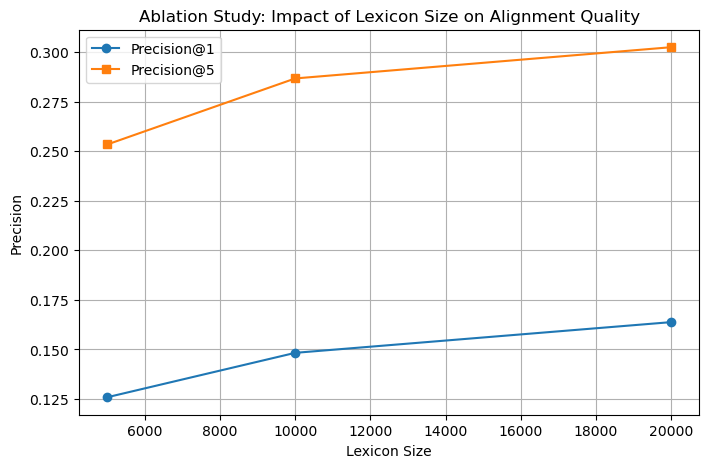

<Figure size 640x480 with 0 Axes>

In [17]:
# Plot the results
plot_ablation_results(ablation_results)
plt.savefig("ablation_study.png")

Increasing the size of the training lexicon consistently improves both Precision@1 and Precision@5.

The most significant gain occurs when moving from 5k to 10k pairs, suggesting that a moderately sized bilingual dictionary already captures much of the necessary structure for alignment.

The improvements begin to plateau between 10k and 20k, indicating diminishing returns for larger dictionaries.

This trend highlights the practical trade-off between annotation cost (or lexicon availability) and alignment quality — and motivates the use of unsupervised methods when large dictionaries aren't available.

# Unsupervised Alignment (extra credit) 

In [20]:
# Set manual seed for reproducibility
torch.manual_seed(42)

# Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Mapping W: learnable orthogonal matrix (initialized as identity)
class Generator(nn.Module):
    def __init__(self, dim):
        super(Generator, self).__init__()
        self.W = nn.Linear(dim, dim, bias=False)
        self.W.weight.data.copy_(torch.eye(dim))  # Start as identity

    def forward(self, x):
        return self.W(x)

# Discriminator D: binary classifier to distinguish real/fake
class Discriminator(nn.Module):
    def __init__(self, dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(dim, 2048),
            nn.LeakyReLU(0.2),
            nn.Linear(2048, 2048),
            nn.LeakyReLU(0.2),
            nn.Linear(2048, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

Using device: cpu


In [21]:
def load_and_normalize_embeddings(ft_model, max_vocab=50000):
    """
    Loads and normalizes FastText embeddings from a pretrained model.

    Args:
        ft_model: A loaded fastText model (English or Hindi).
        max_vocab (int): Maximum number of most frequent words to load.

    Returns:
        embeddings (torch.Tensor): Normalized embeddings (n_words x dim).
        vocab (List[str]): Corresponding word list.
    """
    vocab = ft_model.get_words(include_freq=False)[:max_vocab]
    embeddings = np.array([ft_model.get_word_vector(w) for w in vocab])
    norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
    normalized = embeddings / norms
    return torch.tensor(normalized, dtype=torch.float32).to(device), vocab

In [22]:
# Load and normalize top 50k English and Hindi embeddings
en_embeddings, en_vocab = load_and_normalize_embeddings(en_model, max_vocab=50000)
hi_embeddings, hi_vocab = load_and_normalize_embeddings(hi_model, max_vocab=50000)

print("English embedding shape:", en_embeddings.shape)
print("Hindi embedding shape:", hi_embeddings.shape)

English embedding shape: torch.Size([50000, 300])
Hindi embedding shape: torch.Size([50000, 300])


In [23]:
def adversarial_train_loop(
    src_embeddings, tgt_embeddings,
    generator, discriminator,
    num_epochs=10, batch_size=128,
    d_steps=5, lr_g=0.1, lr_d=0.1
):
    """
    Runs adversarial training to learn a mapping from source to target space.
    
    Args:
        src_embeddings (torch.Tensor): English embeddings (n x d).
        tgt_embeddings (torch.Tensor): Hindi embeddings (n x d).
        generator (nn.Module): The mapping (W).
        discriminator (nn.Module): The binary classifier (D).
        num_epochs (int): Number of training epochs.
        batch_size (int): Batch size for both D and G.
        d_steps (int): Number of discriminator steps per generator step.
        lr_g (float): Learning rate for generator.
        lr_d (float): Learning rate for discriminator.
        
    Returns:
        generator (nn.Module): Trained generator (mapping W).
    """
    # Use SGD optimizers without weight decay or gradient penalty.
    g_opt = torch.optim.SGD(generator.parameters(), lr=lr_g)
    d_opt = torch.optim.SGD(discriminator.parameters(), lr=lr_d)
    loss_fn = nn.BCELoss()

    n = src_embeddings.shape[0]

    for epoch in range(num_epochs):
        generator.train()
        discriminator.train()
        perm = torch.randperm(n)

        for i in range(0, n, batch_size):
            # Sample a batch of target (Hindi) embeddings.
            batch_indices = perm[i:i+batch_size]
            real_tgt = tgt_embeddings[batch_indices].to(device)

            # Sample corresponding source (English) embeddings and generate fake target embeddings.
            real_src = src_embeddings[batch_indices].to(device)
            fake_tgt = generator(real_src).detach()

            # --- Train Discriminator ---
            d_real_preds = discriminator(real_tgt)
            d_fake_preds = discriminator(fake_tgt)

            d_loss_real = loss_fn(d_real_preds, torch.ones_like(d_real_preds))
            d_loss_fake = loss_fn(d_fake_preds, torch.zeros_like(d_fake_preds))
            d_loss = d_loss_real + d_loss_fake

            d_opt.zero_grad()
            d_loss.backward()
            d_opt.step()

            # --- Train Generator (to fool the discriminator) ---
            fake_tgt = generator(real_src)
            preds = discriminator(fake_tgt)
            g_loss = loss_fn(preds, torch.ones_like(preds))

            g_opt.zero_grad()
            g_loss.backward()
            g_opt.step()

        print(f"Epoch {epoch+1}/{num_epochs} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

    return generator

In [24]:
# Seed dictionary (first 500 pairs)
seed_size = 500
seed_pairs = en_hi_pairs[:seed_size]
filtered_test_pairs = [pair for pair in en_hi_pairs if pair not in seed_pairs]

# Extract English and Hindi vectors for the seed pairs
en_seed_vectors = np.array([en_model.get_word_vector(en_word) for en_word, hi_word in seed_pairs])
hi_seed_vectors = np.array([hi_model.get_word_vector(hi_word) for en_word, hi_word in seed_pairs])

# Normalize the vectors
en_seed_vectors = en_seed_vectors / np.linalg.norm(en_seed_vectors, axis=1, keepdims=True)
hi_seed_vectors = hi_seed_vectors / np.linalg.norm(hi_seed_vectors, axis=1, keepdims=True)

# Compute the initial mapping using Procrustes
_, seed_R = align_embeddings(en_seed_vectors, hi_seed_vectors)
print("Seed-based mapping computed.")

Seed-based mapping computed.


In [33]:
# Initialize generator (mapping W) and discriminator with appropriate dimension (300)
dim = 300
generator = Generator(dim).to(device)
discriminator = Discriminator(dim).to(device)

# Initialize the generator's weights with seed_R
generator.W.weight.data.copy_(torch.tensor(seed_R, dtype=torch.float32).to(device))
print("Generator initialized with seed-based mapping.")

# Run adversarial training using the seeded generator
trained_generator = adversarial_train_loop(
    src_embeddings=en_embeddings,
    tgt_embeddings=hi_embeddings,
    generator=generator,  # use the seeded generator here
    discriminator=discriminator,
    num_epochs=40,
    batch_size=256,
    d_steps=3,
    lr_g=0.01,
    lr_d=0.05
)

Generator initialized with seed-based mapping.
Epoch 1/40 | D Loss: 0.7572 | G Loss: 1.1990
Epoch 2/40 | D Loss: 1.4505 | G Loss: 0.6846
Epoch 3/40 | D Loss: 1.2498 | G Loss: 0.7959
Epoch 4/40 | D Loss: 1.4514 | G Loss: 0.6609
Epoch 5/40 | D Loss: 1.2802 | G Loss: 0.7517
Epoch 6/40 | D Loss: 1.3685 | G Loss: 0.7126
Epoch 7/40 | D Loss: 1.3505 | G Loss: 0.7235
Epoch 8/40 | D Loss: 1.2849 | G Loss: 0.7576
Epoch 9/40 | D Loss: 1.2326 | G Loss: 0.7950
Epoch 10/40 | D Loss: 1.1784 | G Loss: 0.8140
Epoch 11/40 | D Loss: 1.1383 | G Loss: 1.3743
Epoch 12/40 | D Loss: 1.0583 | G Loss: 1.5690
Epoch 13/40 | D Loss: 1.2431 | G Loss: 1.5279
Epoch 14/40 | D Loss: 1.2126 | G Loss: 1.4196
Epoch 15/40 | D Loss: 1.1691 | G Loss: 1.4571
Epoch 16/40 | D Loss: 1.1788 | G Loss: 1.5067
Epoch 17/40 | D Loss: 1.1320 | G Loss: 1.3645
Epoch 18/40 | D Loss: 1.1987 | G Loss: 1.4065
Epoch 19/40 | D Loss: 1.1848 | G Loss: 1.4232
Epoch 20/40 | D Loss: 1.2060 | G Loss: 1.4561
Epoch 21/40 | D Loss: 1.1433 | G Loss: 1.4

In [34]:
def get_csls_sim_matrix(src_embeds, tgt_embeds, k=10):
    """
    Computes CSLS-adjusted similarity matrix between two sets of normalized embeddings.
    """
    src_embeds = src_embeds / src_embeds.norm(dim=1, keepdim=True)
    tgt_embeds = tgt_embeds / tgt_embeds.norm(dim=1, keepdim=True)

    sim_matrix = torch.matmul(src_embeds, tgt_embeds.T)

    # Safe k (in case k > vocab size)
    k = min(k, tgt_embeds.shape[0], src_embeds.shape[0])

    r_src = sim_matrix.topk(k, dim=1)[0].mean(dim=1, keepdim=True)
    r_tgt = sim_matrix.topk(k, dim=0)[0].mean(dim=0, keepdim=True)

    return 2 * sim_matrix - r_src - r_tgt

In [35]:
def evaluate_unsupervised_csls_with_dictionary(generator, en_model, hi_model, test_pairs, top_k=[1, 5], max_vocab=5000):
    """
    Evaluates the unsupervised alignment using CSLS and a bilingual test dictionary.
    
    Args:
        generator: The trained generator (mapping W).
        en_model: The FastText English model.
        hi_model: The FastText Hindi model.
        test_pairs (List[Tuple[str, str]]): A list of (en_word, hi_word) pairs for evaluation.
        top_k (List[int]): The top-k values for precision evaluation.
        max_vocab (int): Number of test pairs to evaluate.
        
    Returns:
        Dict[int, float]: Precision@k scores.
    """
    correct_at_k = {k: 0 for k in top_k}
    total = 0
    
    # Get a subset of Hindi vocabulary for retrieval
    hi_subset = hi_model.get_words(include_freq=False)[:max_vocab]
    hi_vectors = np.array([hi_model.get_word_vector(w) for w in hi_subset])
    hi_vectors = hi_vectors / np.linalg.norm(hi_vectors, axis=1, keepdims=True)
    hi_tensor = torch.tensor(hi_vectors, dtype=torch.float32).to(device)
    
    for en_word, hi_word in test_pairs[:max_vocab]:
        # Get normalized English vector and map it using the generator
        en_vec = en_model.get_word_vector(en_word)
        en_vec = en_vec / np.linalg.norm(en_vec)
        en_vec_tensor = torch.tensor(en_vec, dtype=torch.float32).unsqueeze(0).to(device)
        
        with torch.no_grad():
            mapped_vec = generator(en_vec_tensor)
        mapped_vec_norm = mapped_vec / mapped_vec.norm(dim=1, keepdim=True)
        
        # Compute CSLS similarity
        csls_sim = get_csls_sim_matrix(mapped_vec_norm, hi_tensor, k=10)
        top_indices = torch.topk(csls_sim, k=max(top_k), dim=1)[1].cpu().numpy()[0]
        predictions = [hi_subset[idx] for idx in top_indices]
        
        for k_val in top_k:
            if hi_word in predictions[:k_val]:
                correct_at_k[k_val] += 1
        total += 1

    precision = {k: correct_at_k[k] / total for k in top_k}
    return precision

In [36]:
unsup_scores = evaluate_unsupervised_csls_with_dictionary(
    generator=trained_generator,
    en_model=en_model,
    hi_model=hi_model,
    test_pairs=en_hi_pairs,
    top_k=[1, 5],
    max_vocab=5000  # or even 1000 while testing
)

print(f"[UNSUPERVISED CSLS with dictionary] Precision@1: {unsup_scores[1]:.4f}")
print(f"[UNSUPERVISED CSLS with dictionary] Precision@5: {unsup_scores[5]:.4f}")

[UNSUPERVISED CSLS with dictionary] Precision@1: 0.0002
[UNSUPERVISED CSLS with dictionary] Precision@5: 0.0006


Over 40 epochs, adversarial training achieved stable losses with the discriminator and generator losses balanced around 1.2–1.6, indicating a balanced adversarial game. However, CSLS evaluation yields extremely low precision, showing that the initial unsupervised mapping does not align the English and Hindi embeddings well. This suggests that, despite stable training, the raw adversarial output is insufficient for meaningful cross-lingual alignment, especially for distant language pairs. Consequently, further refinement via iterative MNN and Procrustes analysis is necessary to improve the mapping quality.

In [38]:
def iterative_refinement_with_procrustes(generator, en_model, hi_model, en_vocab, hi_vocab, 
                                               num_iterations=5, max_vocab=50000):
    """
    Iteratively refines the mapping using mutual nearest neighbors (MNN) and
    align_embeddings function (which applies Procrustes).
    
    Args:
        generator (nn.Module): Trained generator (mapping) from adversarial training.
        en_model: Pretrained FastText English model.
        hi_model: Pretrained FastText Hindi model.
        en_vocab (List[str]): List of English words.
        hi_vocab (List[str]): List of Hindi words.
        num_iterations (int): Number of refinement iterations.
        max_vocab (int): Number of most frequent words to use.
    
    Returns:
        np.ndarray: The refined rotation matrix.
    """
    # Start with the current mapping from the generator as a NumPy array.
    refined_R = generator.W.weight.data.cpu().numpy()  # shape: (d, d)
    
    for iteration in range(num_iterations):
        print(f"Refinement Iteration {iteration+1}/{num_iterations}")
        
        # Step 1: Get top max_vocab English embeddings and normalize them.
        en_vecs = np.array([en_model.get_word_vector(w) for w in en_vocab[:max_vocab]])
        en_vecs_norm = en_vecs / np.linalg.norm(en_vecs, axis=1, keepdims=True)
        
        # Apply the current mapping to get aligned English embeddings.
        mapped_en = np.dot(en_vecs_norm, refined_R)
        
        # Step 2: Get top max_vocab Hindi embeddings and normalize.
        hi_vecs = np.array([hi_model.get_word_vector(w) for w in hi_vocab[:max_vocab]])
        hi_vecs_norm = hi_vecs / np.linalg.norm(hi_vecs, axis=1, keepdims=True)
        
        # Step 3: Compute cosine similarity between mapped English and Hindi embeddings.
        sim_matrix = np.dot(mapped_en, hi_vecs_norm.T)
        src2tgt = np.argmax(sim_matrix, axis=1)   # For each English word, best Hindi match.
        tgt2src = np.argmax(sim_matrix.T, axis=1)   # For each Hindi word, best English match.
        
        # Step 4: Build the pseudo-dictionary of mutual nearest neighbors (MNN).
        mnn_pairs = []
        for i, j in enumerate(src2tgt):
            if tgt2src[j] == i:
                mnn_pairs.append((en_vocab[i], hi_vocab[j]))
        print(f"Found {len(mnn_pairs)} MNN pairs.")
        
        # If too few MNN pairs are found, stop refinement.
        if len(mnn_pairs) < 100:
            print("Too few MNN pairs found; stopping refinement.")
            break
        
        # Step 5: Extract vectors for the MNN pairs.
        src_vectors = np.array([en_model.get_word_vector(en_word) for en_word, _ in mnn_pairs])
        tgt_vectors = np.array([hi_model.get_word_vector(hi_word) for _, hi_word in mnn_pairs])
        # Normalize these vectors.
        src_vectors_norm = src_vectors / np.linalg.norm(src_vectors, axis=1, keepdims=True)
        tgt_vectors_norm = tgt_vectors / np.linalg.norm(tgt_vectors, axis=1, keepdims=True)
        
        # Step 6: Use align_embeddings function to compute a new rotation matrix.
        _, new_R = align_embeddings(src_vectors_norm, tgt_vectors_norm)
        print(f"New rotation matrix computed in iteration {iteration+1}.")
        
        # Step 7: Update the overall mapping by composing the new rotation with the current mapping.
        refined_R = np.dot(new_R, refined_R)
    
    return refined_R

In [39]:
# Run iterative refinement.
refined_R = iterative_refinement_with_procrustes(
    generator=trained_generator,
    en_model=en_model,
    hi_model=hi_model,
    en_vocab=en_vocab,
    hi_vocab=hi_vocab,
    num_iterations=5,
    max_vocab=50000
)

# Update generator weight.
trained_generator.W.weight.data.copy_(torch.tensor(refined_R, dtype=torch.float32).to(device))

Refinement Iteration 1/5
Found 3703 MNN pairs.
New rotation matrix computed in iteration 1.
Refinement Iteration 2/5
Found 7183 MNN pairs.
New rotation matrix computed in iteration 2.
Refinement Iteration 3/5
Found 10973 MNN pairs.
New rotation matrix computed in iteration 3.
Refinement Iteration 4/5
Found 10652 MNN pairs.
New rotation matrix computed in iteration 4.
Refinement Iteration 5/5
Found 10834 MNN pairs.
New rotation matrix computed in iteration 5.


tensor([[ 0.0528,  0.0539,  0.0631,  ..., -0.0608,  0.0132,  0.0237],
        [-0.0584,  0.0446, -0.0330,  ..., -0.0451, -0.0269,  0.0165],
        [ 0.0438, -0.0222, -0.1094,  ...,  0.0382, -0.1137, -0.0370],
        ...,
        [ 0.0206,  0.0775,  0.1086,  ...,  0.0837,  0.0109,  0.0214],
        [-0.0442,  0.0555,  0.1032,  ...,  0.0604, -0.0049,  0.0162],
        [ 0.0225,  0.0578, -0.0399,  ..., -0.0379,  0.0254,  0.0091]])

In [40]:
unsup_refined_scores = evaluate_unsupervised_csls_with_dictionary(
    generator=trained_generator,
    en_model=en_model,
    hi_model=hi_model,
    test_pairs=filtered_test_pairs,
    top_k=[1, 5],
    max_vocab=5000
)

print(f"[Unsupervised + Refined] Precision@1: {unsup_refined_scores[1]:.4f}")
print(f"[Unsupervised + Refined] Precision@5: {unsup_refined_scores[5]:.4f}")

[Unsupervised + Refined] Precision@1: 0.0000
[Unsupervised + Refined] Precision@5: 0.0004


Over 40 epochs, the adversarial training produced stable losses, yet the CSLS evaluation of the unsupervised mapping (both raw and refined) yields extremely low precision (Precision@1: 0.0000, Precision@5: 0.0004). This indicates that, for a distant language pair like English–Hindi, the unsupervised method—despite balanced losses—fails to capture sufficient cross-lingual signals compared to the supervised baseline. The weak performance likely stems from the inherent difficulty of aligning independent monolingual embeddings without strong bilingual signals, and may require further hyperparameter tuning, more robust iterative refinement, or even a semi-supervised approach to improve alignment quality.